# Cortisol Analysis

In [1]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import pingouin as pg

import biopsykit as bp
from biopsykit.stats import StatsPipeline
from biopsykit.io import load_long_format_csv
from biopsykit.utils.dataframe_handling import multi_xs

from fau_colors import cmaps, register_fausans_font

import matplotlib.pyplot as plt
import seaborn as sns

from carwatch_analysis.io import load_cortisol_samples_reporting_times
from carwatch_analysis.utils import describe_groups_df
from carwatch_analysis.stats import create_unique_night_id
from carwatch_analysis.plotting import multi_paired_plot_auc, paired_plot_auc
from carwatch_analysis.data_processing.saliva import compute_auc_increasing


%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)

theme_kwargs = {"context": "talk", "style": "ticks", "palette": palette}
theme_kwargs_grid = {"context": "talk", "style": "ticks", "palette": palette, "font_scale": 0.8}
sns.set_theme(**theme_kwargs)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

export = True

pg.options["round"] = 4

palette

Successfully registered FAU Sans font.


[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Setup Paths

In [3]:
base_path = Path("../..")
export_path = base_path.joinpath("exports")
result_path = base_path.joinpath("results")
stats_path = result_path.joinpath("statistics")

img_path = result_path.joinpath("plots")

paper_path = Path(json.load(Path("../paper_path.json").open(encoding="utf-8"))["paper_path"])
paper_img_path = paper_path.joinpath("img")

bp.utils.file_handling.mkdirs([result_path, stats_path, img_path, paper_img_path])

## Load Data

In [4]:
cort_features = load_long_format_csv(export_path.joinpath("cortisol_features_processed_all_reporting_types.csv"))
cort_features = create_unique_night_id(cort_features)
cort_features.head()

cortisol
subject night night_id condition   reporting_type      saliva_feature          
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport auc_g             614.03
                                                       auc_i             443.23
                                                       ini_val             2.80
                                                       max_inc            10.66
                                                       max_val            13.46

In [5]:
# Don't consider IMU and IMU_App because the cortisol features are the same as
# Selfreport and App since only the wake onset differs, but not the sampling times
reporting_types_fine = [
    "Naive",
    "AW & ST: Selfreport (without App)",
    "AW & ST: Selfreport (with App)",
    "AW & ST: App",
    "AW: Sensor, ST: Selfreport (without App)",
    "AW: Sensor, ST: Selfreport (with App)",
    "AW: Sensor, ST: App",
]
reporting_types_coarse = [
    "Naive",
    "AW & ST: Selfreport",
    "AW & ST: App",
    "AW: Sensor, ST: Selfreport",
    "AW: Sensor, ST: App",
]

reporting_types_fine_rename = [s.replace("without", "w/o").replace("with", "w/") for s in reporting_types_fine]
rename_mapper_reporting_types = dict(zip(reporting_types_fine, reporting_types_fine_rename))

reporting_types_fine = reporting_types_fine_rename

cort_features = cort_features.rename(rename_mapper_reporting_types, level="reporting_type")

In [6]:
dict_saliva_export = {}

## S1

### Data Selection

In [7]:
cort_features_analysis = cort_features.copy()
cort_features_analysis = cort_features_analysis.xs("ini_val", level="saliva_feature", drop_level=False)
cort_features_analysis = cort_features_analysis.reindex(reporting_types_fine, level="reporting_type")
cort_features_analysis.head()

cortisol
subject night night_id condition   reporting_type                       saliva_feature          
AB19E   0     AB19E_0  Known Alarm Naive                                ini_val             2.80
                                   AW & ST: Selfreport (w/o App)        ini_val             2.80
                                   AW: Sensor, ST: Selfreport (w/o App) ini_val             2.80
AB31R   0     AB31R_0  Spontaneous Naive                                ini_val            10.28
                                   AW & ST: Selfreport (w/o App)        ini_val            10.28

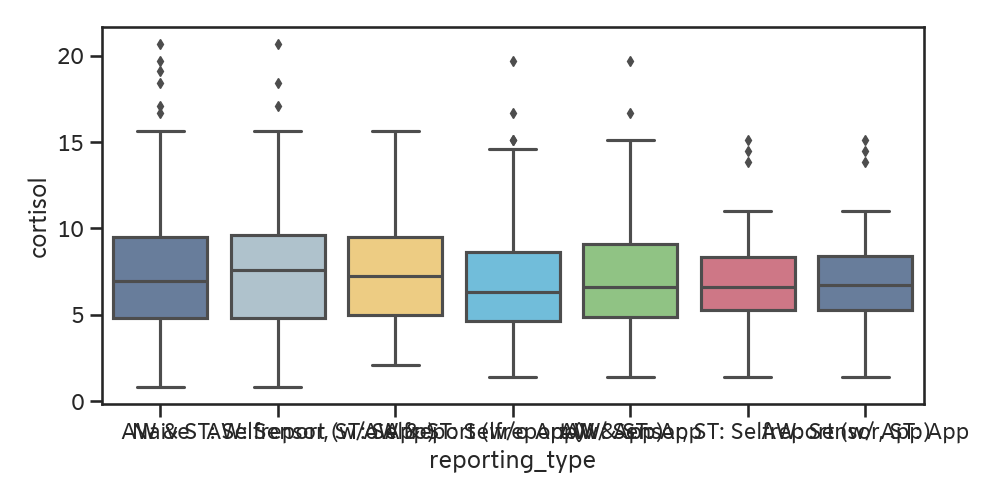

In [8]:
fig, ax = plt.subplots()

sns.boxplot(
    data=cort_features_analysis.reset_index(), x="reporting_type", y="cortisol", palette=cmaps.faculties_light, ax=ax
)
fig.tight_layout()

## $AUC_I$

### Data Selection

In [9]:
cort_features_analysis = cort_features.copy()
cort_features_analysis = cort_features_analysis.xs("auc_i", level="saliva_feature", drop_level=False)
cort_features_analysis = cort_features_analysis.reindex(reporting_types_fine, level="reporting_type")
cort_features_analysis.head()

cortisol
subject night night_id condition   reporting_type                       saliva_feature          
AB19E   0     AB19E_0  Known Alarm Naive                                auc_i            432.975
                                   AW & ST: Selfreport (w/o App)        auc_i            443.230
                                   AW: Sensor, ST: Selfreport (w/o App) auc_i            443.230
AB31R   0     AB31R_0  Spontaneous Naive                                auc_i             16.875
                                   AW & ST: Selfreport (w/o App)        auc_i             18.965

### Stats

In [10]:
reporting_types = ["Naive", "AW & ST: Selfreport (w/ App)", "AW & ST: App"]

data_analysis = cort_features_analysis.reindex(reporting_types, level="reporting_type")

pipeline = StatsPipeline(
    steps=[("prep", "normality"), ("prep", "equal_var"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")],
    params={
        "dv": "cortisol",
        "within": "reporting_type",
        "subject": "night_id",
        "multicomp": {"method": "bonf", "levels": False},
    },
)

pipeline.apply(data_analysis)
pipeline.export_statistics(stats_path.joinpath("stats_auci_reporting_type.xlsx"))
pipeline.display_results()

/Users/Richer/Documents/PhD/Projects/HealthPsychology/CARWatch/Code/carwatch_analysis/.venv/lib/python3.9/site-packages/biopsykit/stats/stats.py:479: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


<font size="3"><b> Overview </b></font>

,dv,within,subject,multicomp
parameter,cortisol,reporting_type,night_id,"{'method': 'bonf', 'levels': False}"


,prep,prep,test,posthoc
parameter,normality,equal_var,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

,W,pval,normal
reporting_type,,,
Naive,0.9901,0.1767,True
AW & ST: Selfreport (w/ App),0.9918,0.8367,True
AW & ST: App,0.9898,0.7823,True


**Test for Homoscedasticity (Equal Variances)**

,W,pval,equal_var
levene,0.688,0.5032,True


<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,reporting_type,2,154,24.5021,0.0,0.0,0.0001,0.805,False,0.7578,0.0


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,p-corr
0,reporting_type,AW & ST: App,AW & ST: Selfreport (w/ App),True,True,4.2771,77.0,two-sided,0.0001,355.376,0.0170,0.0003
1,reporting_type,AW & ST: App,Naive,True,True,5.7577,77.0,two-sided,0.0000,8.093e+04,0.0291,0.0000
2,reporting_type,AW & ST: Selfreport (w/ App),Naive,True,True,3.6470,77.0,two-sided,0.0005,47.509,0.0122,0.0015


### Boxplots

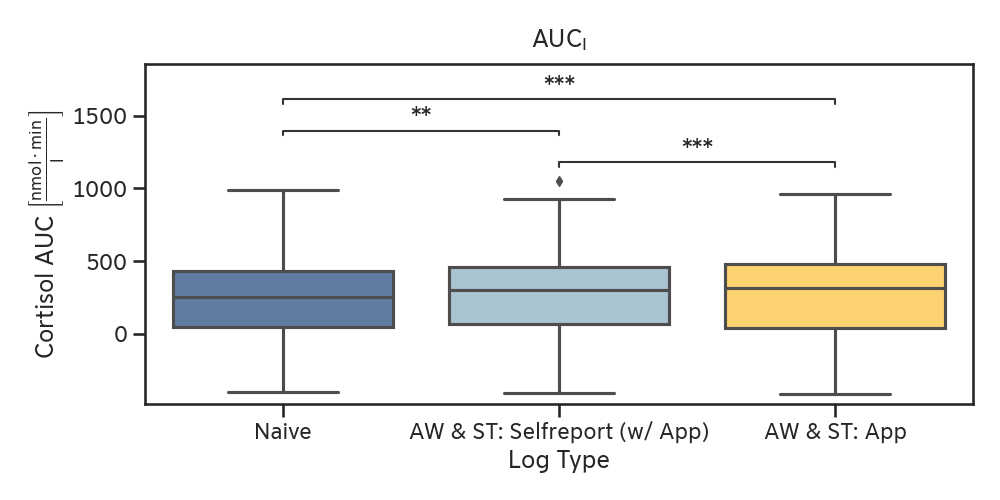

In [11]:
box_pairs, pvalues = pipeline.sig_brackets("posthoc", stats_effect_type="within", plot_type="single")

fig, ax = plt.subplots(figsize=(10, 5))

bp.protocols.plotting.saliva_feature_boxplot(
    data=data_analysis,
    x="reporting_type",
    saliva_type="cortisol",
    feature="auc_i",
    order=reporting_types,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    palette=cmaps.faculties_light,
    ax=ax,
)
ax.set_title("$AUC_I$", pad=12)
ax.set_xlabel("Log Type")
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.05)

fig.tight_layout()

for path in [img_path]:
    bp.utils.file_handling.export_figure(fig, "img_boxplot_auci", path, ["pdf", "png"], dpi=300)

### Paired Plots

In [12]:
data_increase = compute_auc_increasing(cort_features_analysis.reindex(reporting_types, level="reporting_type"), "auc_i")
dict_saliva_export["AUC_I_reporting_Type_Increase"] = data_increase
data_increase

,Naive | AW & ST: Selfreport (w/ App),Naive | AW & ST: App,AW & ST: Selfreport (w/ App) | AW & ST: App
increasing,,,
True,46.0,83.0,72.0
False,54.0,17.0,28.0


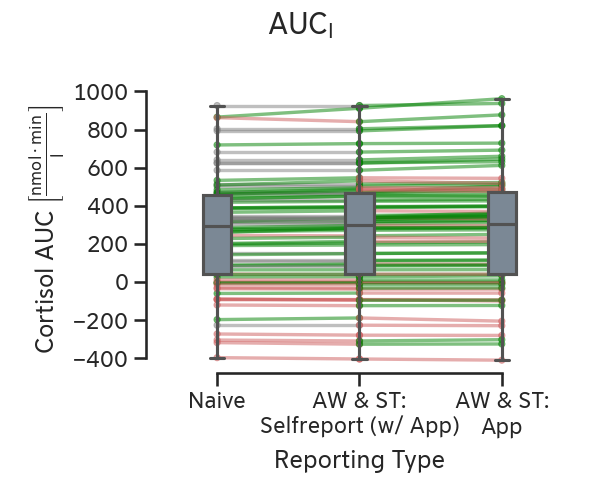

In [13]:
fig, ax = paired_plot_auc(
    data=cort_features_analysis, saliva_feature="auc_i", reporting_types=reporting_types, figsize=(6, 5)
)

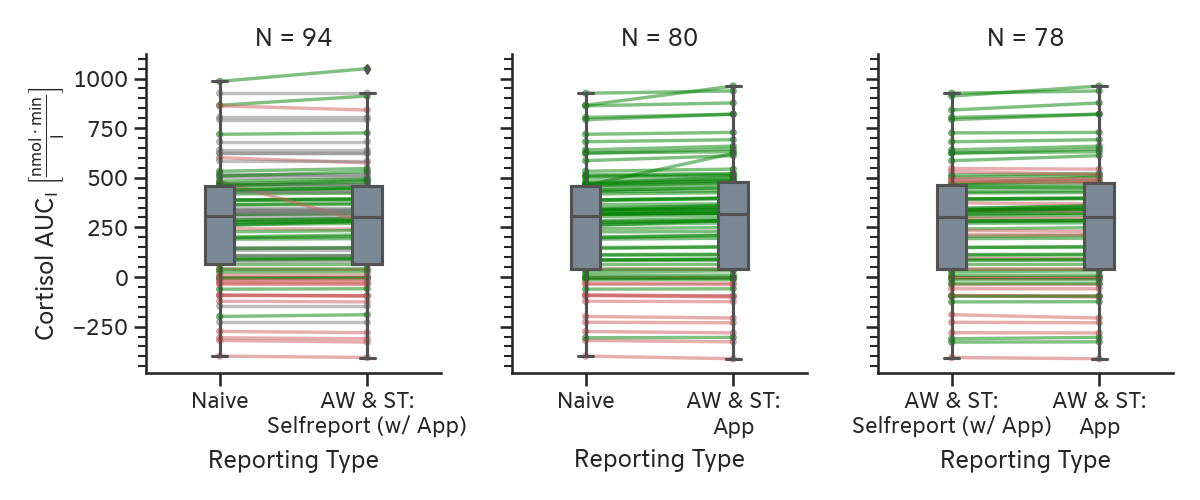

In [15]:
reporting_types = ["Naive", "AW & ST: Selfreport (w/ App)", "AW & ST: App"]

fig, axs = multi_paired_plot_auc(
    data=cort_features_analysis, saliva_feature="auc_i", reporting_types=reporting_types, figsize=(12, 5)
)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_pairedplot_auci", path, ["pdf", "png"], dpi=300)

## S1 and $AUC_I$ in Table

In [16]:
saliva_features = ["ini_val", "auc_i"]

s1_auc_result = cort_features.reindex(saliva_features, level="saliva_feature")
s1_auc_result = s1_auc_result.groupby(["reporting_type", "saliva_feature"]).agg(["mean", "std"])
s1_auc_result = s1_auc_result["cortisol"].unstack("saliva_feature")
s1_auc_result = s1_auc_result.swaplevel(0, 1, axis=1).sort_index(axis=1)
s1_auc_result = s1_auc_result.reindex(reporting_types_fine, level="reporting_type")
s1_auc_result = s1_auc_result.reindex(saliva_features, level="saliva_feature", axis=1)
s1_auc_result.round(2)

saliva_feature                       ini_val         auc_i        
                                        mean   std    mean     std
reporting_type                                                    
Naive                                   7.42  3.75  246.44  268.20
AW & ST: Selfreport (w/o App)           7.54  3.84  241.90  249.18
AW & ST: Selfreport (w/ App)            7.21  3.64  274.23  294.06
AW & ST: App                            7.37  3.77  277.63  303.33
AW: Sensor, ST: Selfreport (w/o App)    7.39  3.02  246.51  246.94
AW: Sensor, ST: Selfreport (w/ App)     7.19  2.86  293.82  302.79
AW: Sensor, ST: App                     7.20  2.93  307.60  324.33

## Export

In [17]:
bp.io.write_pandas_dict_excel(dict_saliva_export, result_path.joinpath("saliva_results.xlsx"))